In [1]:
import pandas as pd
import numpy as np
import h2o
from h2o.estimators import H2OGradientBoostingEstimator
from h2o.estimators import H2OXGBoostEstimator
from h2o.grid.grid_search import H2OGridSearch
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_curve, auc

In [2]:
h2o.init(port=12345)

Checking whether there is an H2O instance running at http://localhost:12345..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "21.0.5" 2024-10-15; OpenJDK Runtime Environment (build 21.0.5+11-Ubuntu-1ubuntu124.04); OpenJDK 64-Bit Server VM (build 21.0.5+11-Ubuntu-1ubuntu124.04, mixed mode, sharing)
  Starting server from /home/lucasmalheiros/Documents/Pesquisa Operacional/tcc-relax-and-fix/venv/lib/python3.12/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp_v7xphah
  JVM stdout: /tmp/tmp_v7xphah/h2o_lucasmalheiros_started_from_python.out
  JVM stderr: /tmp/tmp_v7xphah/h2o_lucasmalheiros_started_from_python.err
  Server is running at http://127.0.0.1:12345
Connecting to H2O server at http://127.0.0.1:12345 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/Sao_Paulo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,1 month and 19 days
H2O_cluster_name:,H2O_from_python_lucasmalheiros_c35iqk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.868 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [3]:
def convert_to_h2o_frame(data: pd.DataFrame) -> h2o.H2OFrame:
    """Converte um pd.DataFrame em um h2o.H2OFrame"""
    print('Performing conversion from pd.DataFrame to h2o.H2OFrame...')
    # Colunas de datas
    cols_to_date = [col for col in data.dtypes[data.dtypes == 'datetime64[ns]'].index]
    # Colunas a converter para categórica
    cols_to_factor = [col for col in data.dtypes[(data.dtypes == 'object') | (data.dtypes == 'category')].index]
    # Colunas a converter a numeric
    cols_numerics = [col for col in data.dtypes[(data.dtypes != 'object') & (data.dtypes != 'category') & (data.dtypes != 'datetime64[ns]')].index]
    # Adicionar os tipos de colunas ao dicionário col_dtypes
    col_dtypes = {}
    for col in cols_to_date:
        col_dtypes[col] = 'time'
    for col in cols_to_factor:
        col_dtypes[col] = 'enum'
    for col in cols_numerics:
        col_dtypes[col] = 'numeric'
    # Converte a h2o
    data = h2o.H2OFrame(data, column_types=col_dtypes, na_strings=['NA', 'none', 'None', 'nan', 'NaN', '<NA>'])
    print('Successful conversion from pd.DataFrame to h2o.H2OFrame.')
    return data

# Data preparation

In [6]:
# Resultados
df_resultados = pd.read_csv('datasets/instances_results.csv')
df_resultados = df_resultados[['Instancias'] + [col for col in df_resultados.columns if col.startswith('Obj_') or col.startswith('Time_')]]
df_resultados = df_resultados[df_resultados['Obj_RF_T_0'] != np.inf]  # Remove infactíveis

In [10]:
# Features criadas de create_features_dataset.py
df_features = pd.read_csv('datasets/multi_plant_instance_features.csv')

In [11]:
df = df_features.merge(df_resultados, left_on='instance', right_on='Instancias', how='inner').drop(columns=['Instancias', 'instance'])

In [12]:
df.head(3)

,num_products,num_plants,num_periods,binary_vars,min_demand,avg_demand,max_demand,std_demand,cv_demand,p75_demand,...,Obj_RF_6_1,Time_RF_6_1,Obj_RF_6_2,Time_RF_6_2,Obj_RF_6_3,Time_RF_6_3,Obj_RF_6_4,Time_RF_6_4,Obj_RF_T_0,Time_RF_T_0
0,120,2,12,2880,1,91.366667,180,52.990103,0.579972,138.0,...,811118.49,1200.63,810455.47,1202.5,810826.56,1338.43,809546.92,1437.74,809910.65,1800.1
1,60,20,12,14400,1,90.673819,180,51.952348,0.572959,135.0,...,2404219.27,1018.31,2404144.93,1320.7,2404372.62,1543.79,2406932.24,1640.32,2404240.72,952.5
2,120,6,12,8640,1,91.228125,180,52.583777,0.576399,138.0,...,1991086.02,1214.94,1976005.90,1800.7,1972303.15,1800.97,1942660.20,1800.62,2106419.81,1800.2


# Construção de targets

In [13]:
obj_columns = [col for col in df.columns if col.startswith('Obj_')]
time_columns = [col for col in df.columns if col.startswith('Time_')]

## Target em função objetivo (BEST)

In [14]:
# Seleciona para cada instância o método com menor função objetivo para a coluna BEST
df['BEST'] = df[obj_columns].idxmin(axis=1)
df['BEST'] = df['BEST'].str.replace('Obj_', '')

In [15]:
df['BEST'].value_counts()

BEST
RF_T_0    163
RF_2_0     50
RF_1_0     47
RF_3_1     40
RF_6_4     33
RF_6_0     33
RF_4_2     31
RF_3_0     30
RF_2_1     29
RF_6_3     27
RF_4_1     27
RF_3_2     21
RF_6_1     20
RF_6_2     16
RF_4_0     16
RF_4_3     15
Name: count, dtype: int64

## Target com compromisso de tempo (BEST_TIME)

In [16]:
for obj_col, time_col in zip(obj_columns, time_columns):
    df[f'Adjusted_{obj_col}'] = (
        df[obj_col] * np.maximum(np.log(df[time_col]) / np.log(1000), 1)
    )
adjusted_columns = [col for col in df.columns if col.startswith('Adjusted_')]

In [17]:
# Seleciona para cada instância o método com menor função objetivo para a coluna BEST
df['BEST_TIME'] = df[adjusted_columns].idxmin(axis=1)
df['BEST_TIME'] = df['BEST_TIME'].str.replace('Adjusted_Obj_', '')

In [18]:
df['BEST_TIME'].value_counts()

BEST_TIME
RF_1_0    110
RF_T_0     97
RF_2_0     57
RF_6_0     34
RF_4_2     33
RF_2_1     31
RF_3_1     29
RF_3_2     27
RF_6_4     27
RF_3_0     26
RF_6_2     24
RF_6_1     24
RF_6_3     22
RF_4_3     22
RF_4_1     19
RF_4_0     16
Name: count, dtype: int64

# Preprocessamento de dados

## Drop Obj_ e Time_

In [19]:
df = df.drop(columns=obj_columns + time_columns + adjusted_columns)

In [20]:
# Embaralhar dataset
df = df.sample(frac=1)

In [21]:
# Transformar em classificação binária
df['BEST'] = df['BEST'].apply(lambda x: 'Gurobi' if x == 'RF_T_0' else 'RF')
df['BEST_TIME'] = df['BEST_TIME'].apply(lambda x: 'Gurobi' if x == 'RF_T_0' else 'RF')

## Convert para H2O frame

In [22]:
# Conversão para H2O frame
hf = convert_to_h2o_frame(df)

Performing conversion from pd.DataFrame to h2o.H2OFrame...
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Successful conversion from pd.DataFrame to h2o.H2OFrame.


In [23]:
# Train test split
hf_train, hf_test = hf.split_frame(ratios=[.8], seed=2112)

# Treino (GBM)

In [24]:
target = 'BEST'
predictors = [c for c in hf_train.columns if c not in ['BEST', 'BEST_TIME']]

In [25]:
gbm_model = H2OGradientBoostingEstimator(
    nfolds=20,
    keep_cross_validation_predictions=True,
    seed=2112,
    stopping_rounds=10,
    stopping_metric="AUTO",
    stopping_tolerance=0.001,
    balance_classes=False
)

In [26]:
xgboost_model = H2OXGBoostEstimator(booster='dart',
                                    normalize_type="tree",
                                    seed=2112,
                                    nfolds=10,
                                    keep_cross_validation_predictions=True)

In [27]:
# Hiper Parâmetros
hyper_params = {
    "learn_rate": list(
        np.round(np.arange(0.01, 0.1, 0.01), 3)
    ),  # Narrowed range for learning rate list(np.round(np.arange(0.05, 0.3, 0.05), 3)),
    "max_depth": list(
        np.arange(5, 10, 1)
    ),  # Reduced maximum depth list(np.arange(5, 15, 1)),
    "ntrees": list(
        np.arange(50, 150, 20)
    ),  # Increased number of trees list(np.arange(20, 70, 10)),
    "sample_rate": list(
        np.round(np.arange(0.5, 0.9, 0.1), 3)
    ),  # Adjusted sample rate range list(np.round(np.arange(0.5, 1.0, 0.1), 3)),
    "col_sample_rate": list(
        np.round(np.arange(0.5, 1.0, 0.1), 3)
    ),  # Slightly adjusted col sample rate range list(np.round(np.arange(0.3, 1.0, 0.1), 3)),
}
# Tipo de pesquisa da grid. Em caso de RandomDiscrete, corre até max_models(n modelos)
search_criteria = {
    "strategy": "RandomDiscrete",
    "max_models": 10,
    # "max_runtime_secs": 180,
    "seed": 1
}

In [28]:
# # Construir grid com parâmetros e critérios de procura de melhor modelo
# grid = H2OGridSearch(model=gbm_model, 
#                      search_criteria=search_criteria, 
#                      hyper_params=hyper_params)
# # Treinar grid
# grid.train(x=predictors, y=target, training_frame=hf_train)

In [29]:
# gbm_grid = grid.get_grid(sort_by="rmse", decreasing=False)
# model = gbm_grid.models[0]

In [30]:
model = gbm_model
model.train(x=predictors, y=target, training_frame=hf_train);

gbm Model Build progress: |

/home/lucasmalheiros/Documents/Pesquisa Operacional/tcc-relax-and-fix/venv/lib/python3.12/site-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [max_demand, num_periods, min_inventory_cost, min_transportation_cost, max_inventory_cost, p50_inventory_cost]
  warnings.warn(mesg["message"], RuntimeWarning)
/home/lucasmalheiros/Documents/Pesquisa Operacional/tcc-relax-and-fix/venv/lib/python3.12/site-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: early stopping is enabled but neither score_tree_interval or score_each_iteration are defined. Early stopping will not be reproducible!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%


# Avaliação das métricas de treino

In [31]:
# Variáveis mais importantes na escolha
importancia_var = model.varimp(use_pandas=True)
importancia_var

,variable,relative_importance,scaled_importance,percentage
0,kurt_capacity,86.296814,1.000000,0.197597
1,binary_vars,69.175674,0.801602,0.158394
2,total_setup_cost,58.899883,0.682527,0.134865
3,min_utilization,47.656979,0.552245,0.109122
4,iqr_transportation_cost,31.455757,0.364507,0.072026
5,avg_setup_cost,27.465837,0.318272,0.062890
6,max_utilization,24.556065,0.284554,0.056227
7,avg_setup_time,13.391972,0.155185,0.030664
8,std_capacity,11.322621,0.131206,0.025926
9,cv_capacity,9.320844,0.108009,0.021342


PartialDependencePlot progress: |

████████████████████████████████████████████████| (done) 100%


[PartialDependence: Partial Dependence Plot of model GBM_model_python_1734839180088_1 on column 'min_utilization'.
min_utilization    mean_response    stddev_response    std_error_mean_response
-----------------  ---------------  -----------------  -------------------------
0.475032           0.771438         0.301176           0.0135919
0.504765           0.771438         0.301176           0.0135919
0.534499           0.771438         0.301176           0.0135919
0.564232           0.771438         0.301176           0.0135919
0.593965           0.771438         0.301176           0.0135919
0.623699           0.771438         0.301176           0.0135919
0.653432           0.771438         0.301176           0.0135919
0.683165           0.776506         0.297705           0.0134353
0.712898           0.729409         0.337046           0.0152107
0.742632           0.762289         0.315134           0.0142218
0.772365           0.767033         0.31048            0.0140118
0.802098  

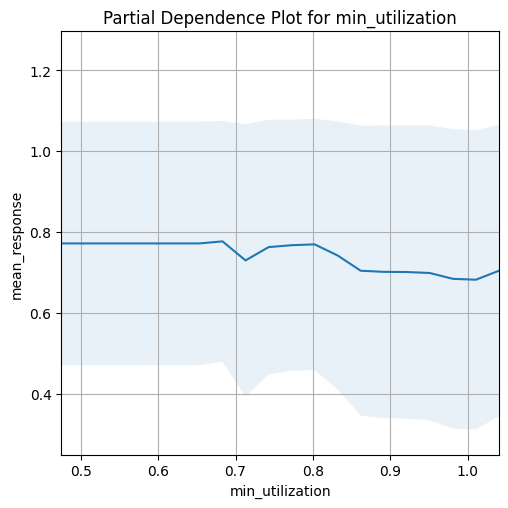

In [48]:
model.partial_plot(frame=hf_train, cols=['min_utilization'], figsize=(5, 5))#, targets=['RF_T_0', 'RF_1_0']);

In [35]:
# Previsões
actual = hf_train[target].as_data_frame(use_multi_thread=True)[target]
predictions = model.cross_validation_holdout_predictions()
predict = predictions[0].as_data_frame(use_multi_thread=True)['predict']

/home/lucasmalheiros/Documents/Pesquisa Operacional/tcc-relax-and-fix/venv/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/lucasmalheiros/Documents/Pesquisa Operacional/tcc-relax-and-fix/venv/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [36]:
# Confusion matrix
cm = confusion_matrix(actual, predict)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[110  26]
 [ 16 339]]


In [37]:
# Precisão
cm.trace() / cm.sum()

np.float64(0.9144602851323829)

In [38]:
recall_per_class = np.diag(cm) / np.sum(cm, axis=1)
macro_average_recall = np.mean(recall_per_class)
print(f"Macro-Average Recall: {macro_average_recall:.4f}")

Macro-Average Recall: 0.8819


In [39]:
# F1 score
f1 = f1_score(actual, predict, average='weighted')
print(f'\nF1 Score: {f1:.4f}')


F1 Score: 0.9134


# Avaliação no dataset de teste

In [40]:
# Previsões sobre teste
actual_test = hf_test[target].as_data_frame(use_multi_thread=True)[target]
predictions_test = model.predict(hf_test)
predict_test = predictions_test[0].as_data_frame(use_multi_thread=True)['predict']

/home/lucasmalheiros/Documents/Pesquisa Operacional/tcc-relax-and-fix/venv/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/home/lucasmalheiros/Documents/Pesquisa Operacional/tcc-relax-and-fix/venv/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [41]:
# Confusion matrix
cm = confusion_matrix(actual_test, predict_test)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[21  6]
 [ 9 71]]


In [42]:
# Precisão
cm.trace() / cm.sum()

np.float64(0.8598130841121495)

In [43]:
# F1 score
f1 = f1_score(actual_test, predict_test, average='weighted')
print(f'\nF1 Score: {f1:.4f}')


F1 Score: 0.8622


In [613]:
# h2o.cluster().shutdown()